In [1]:
import torch
import numpy as np
import pandas as pd
from DNN_module import Net

%run NCoinDP_functions.ipynb

# OU Processes Performance Evaluation

In [130]:
nums = [500, 1000, 3000]
scenarios = ["S1", "S2", "S3"]
nsim = 50

S_NCoin = []
S_MLE = []
# n = 500


for n in nums:
    S_NCoin_n = []
    S_MLE_n = []
    delta = 1/52
    obtime = np.arange(0,n+1)/n * n * delta

    for i in range(len(scenarios)):
        # load test data 
        test_save_name = '../depot_hyun/hyun/test_data/OU_test_n'+ str(n) + '_' + scenarios[i] +'.pt'
        tmp = torch.load(test_save_name)
        #print(torch.mean(net(OU_summary(tmp[0][0])),0))
        S_tmp = []
        for j in range(4):
            S_tmp.append(RMSE(MLE_OU(tmp[0][j], obtime, delta), tmp[1][j]))
        S_MLE_n.append(S_tmp)
        
        S_1 = []
        for sim in range(nsim):
            model_save_name = 'n_' + str(n) + '_' + str(sim)+'.pt'
            path = F"nets/OU/{model_save_name}"

            # load net
            net = Net(D_in = 5, D_out = 3)
            net.load_state_dict(torch.load(path))

            # set to cpu not gpu
            torch.set_default_device('cpu')
            net.eval()
            # 0 : S1, 1: S2, 2: S3, 3:S4
            S_2 = []
            for j in range(4):
                tmp2 = RMSE(net(OU_summary(tmp[0][j])), tmp[1][j])
                S_2.append(tmp2)
            S_1.append(S_2)
        S_NCoin_n.append(S_1)
        print("======== n=" + str(n) + " ======== " + str(scenarios[i]) + ":completed ========")
    S_MLE.append(S_MLE_n)
    S_NCoin.append(S_NCoin_n)

======== n=500 ======== S1:completed ========
======== n=500 ======== S2:completed ========
======== n=500 ======== S3:completed ========
======== n=1000 ======== S1:completed ========
======== n=1000 ======== S2:completed ========
======== n=1000 ======== S3:completed ========
======== n=3000 ======== S1:completed ========
======== n=3000 ======== S2:completed ========
======== n=3000 ======== S3:completed ========


In [131]:
# GMM
df = pd.read_csv('GMM/GMM_OU.txt', sep="\t")
GMM_results = torch.tensor(df.values)
S_GMM_OU = []
for k in range(len(nums)):
    S_GMM_n = []
    tmp_n = GMM_results[k].detach().cpu().numpy().tolist()
    for i in range(len(scenarios)):
        S_tmp = tmp_n[(4*i):(4*i+4)]
        S_GMM_n.append(S_tmp)
    S_GMM_OU.append(S_GMM_n)

# MCMC
df = pd.read_csv('MCMC_OU.txt', sep="\t")
MCMC_results = torch.tensor(df.values)
S_MCMC_OU = []
for k in range(len(nums)):
    S_MCMC_n = []
    tmp_n = MCMC_results[k].detach().cpu().numpy().tolist()
    for i in range(len(scenarios)):
        S_tmp = tmp_n[(4*i):(4*i+4)]
        S_MCMC_n.append(S_tmp)
    S_MCMC_OU.append(S_MCMC_n)

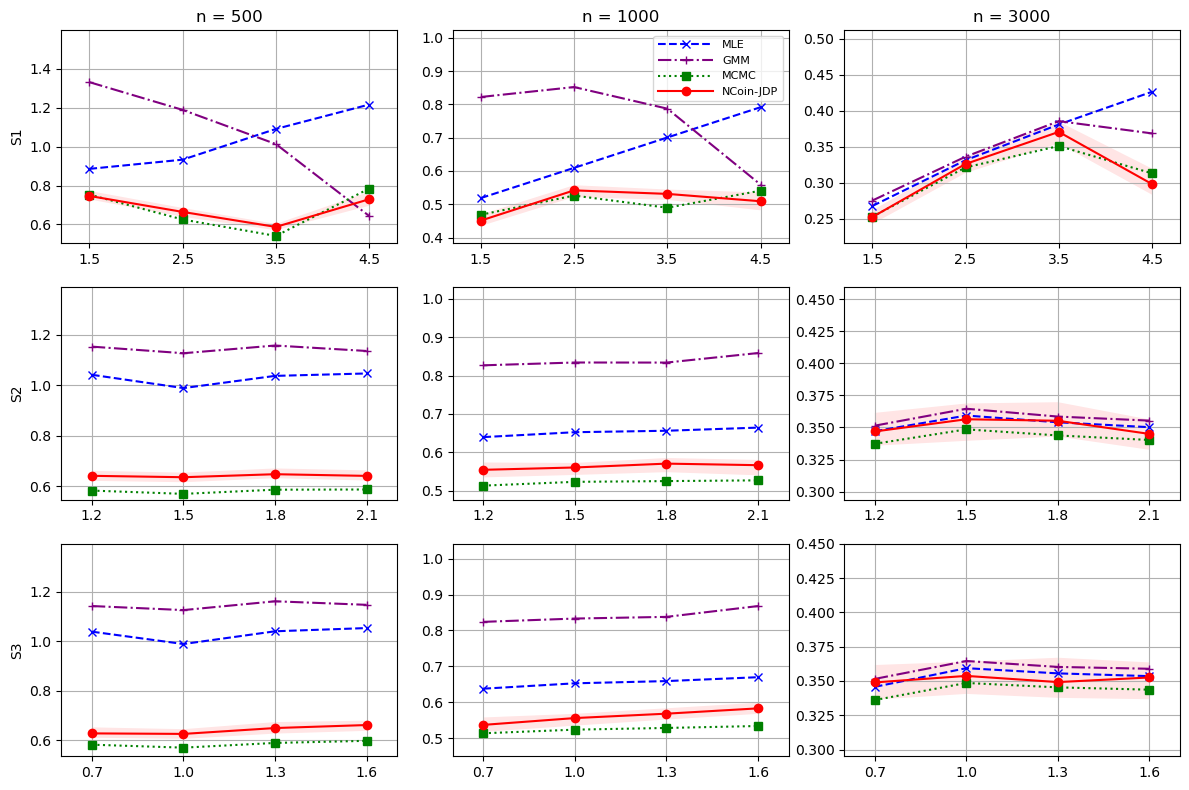

In [132]:
fig, axs = plt.subplots(3, 3)

fig.set_figwidth(12)
fig.set_figheight(8)

x_S = [[1.5, 2.5, 3.5, 4.5],
 [1.2, 1.5, 1.8, 2.1],
 [0.7, 1.0, 1.3, 1.6]]

xlim = [[1.2, 4.8], [1.1, 2.2], [0.6, 1.7]]
axs[0, 0].set(ylabel = "S1")
axs[1, 0].set(ylabel = "S2")
axs[2, 0].set(ylabel = "S3")
    
axs[0, 0].set_title('n = 500')
axs[0, 1].set_title('n = 1000')
axs[0, 2].set_title('n = 3000')
    
for j in range(3):
    for i in range(3):
        axs[i, j].plot(x_S[i], S_MLE[j][i], linestyle = '--',marker = 'x', color = "blue")
        axs[i, j].plot(x_S[i], S_GMM_OU[j][i], linestyle = '-.',marker = '+',color = "purple")
        axs[i, j].plot(x_S[i], S_MCMC_OU[j][i], linestyle = 'dotted',marker = 's',color = "green")
        
        axs[i, j].set_xlim(xlim[i])
        axs[i, j].set_xticks(x_S[i])
        axs[i, j].plot(x_S[i], np.median(S_NCoin[j][i],0), color = "red", marker = 'o')
        axs[0, 1].legend(['MLE', 'GMM', 'MCMC', 'NCoin-JDP'], loc = "upper right", fontsize=8, handlelength=5) 
            
        
        ymin = np.min(S_NCoin[j][i], 0)
        ymax = np.max(S_NCoin[j][i], 0)
        
        yQ1 = np.quantile(S_NCoin[j][i], .05, 0)
        yQ3 = np.quantile(S_NCoin[j][i], .95, 0)
        
        axs[i, j].fill_between(x_S[i], yQ1, yQ3, where = yQ3 >yQ1, facecolor ='red', alpha = 0.1) 
        #axs[i, j].fill_between(x_S[i], ymin, ymax, where = ymax >ymin, facecolor ='red', alpha = 0.05) 
        
        axs[i, j].set_ylim([min(ymin)*0.9,max(np.append(ymax,max(np.append(S_MLE[j][i],S_GMM_OU[j][i]) )) )*1.2 ])
        axs[i, j].grid()
fig.tight_layout()
plt.savefig("plots/OU.pdf") 

# Sensitivity Analysis

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from DNN_module import Net
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

%run NCoinDP_functions.ipynb

In [3]:
net0 = Net(D_in = 5, D_out = 3, H = 64, H2 = 64, H3 = 64)
net1 = Net(D_in = 5, D_out = 3, H = 256, H2 = 256, H3 = 256)
net2 = Net(D_in = 5, D_out = 3, H = 512, H2 = 512, H3 = 512)


def total_params(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

print(total_params(net0))
print(total_params(net1))
print(total_params(net2))

9283
135427
532995


In [ ]:
n = 3000
scenarios = ["S1", "S2", "S3"]
nsim = 50

nets = [64, 128, 256, 512]

S_0 = []
S_MLE_0 = []

delta = 1/52
obtime = np.arange(0,n+1)/n * n * delta

for i in range(len(scenarios)):
    # load test data 
    test_save_name = '../depot_hyun/hyun/test_data/OU_test_n3000'+'_' + scenarios[i] +'.pt'
    tmp = torch.load(test_save_name)
    #print(torch.mean(net(OU_summary(tmp[0][0])),0))
    S_MLE_1 = []
    for j in range(4):
        S_MLE_1.append(RMSE(MLE_OU(tmp[0][j], obtime, delta), tmp[1][j]))
    S_MLE_0.append(S_MLE_1)
        
    S_1 = []
    
    for k in range(len(nets)):
        S_2 = []
        for sim in range(nsim):
            if nets[k] == 128:
                model_save_name = 'n_3000' + '_' + str(sim)+'.pt'
                path = F"nets/OU/{model_save_name}"

                # load net
                net = Net(D_in = 5, D_out = 3)
                net.load_state_dict(torch.load(path))

                # set to cpu not gpu
                torch.set_default_device('cpu')
                net.eval()
                # 0 : S1, 1: S2, 2: S3, 3:S4
                S_3 = []

                for j in range(4):
                    tmp2 = RMSE(net(OU_summary(tmp[0][j])), tmp[1][j])
                    S_3.append(tmp2)
                S_2.append(S_3)

            else:
                model_save_name = 'net'+ str(nets[k]) + '_' + str(sim)+ '.pt'
                path = F"nets/SA/{model_save_name}"

                # load net
                net = Net(D_in = 5, D_out = 3, H = nets[k], H2 = nets[k], H3 = nets[k])
                net.load_state_dict(torch.load(path))
                
                # set to cpu not gpu
                torch.set_default_device('cpu')
                net.eval()
                # 0 : S1, 1: S2, 2: S3, 3:S4
                S_3 = []

                for j in range(4):
                    tmp2 = RMSE(net(OU_summary(tmp[0][j])), tmp[1][j])
                    S_3.append(tmp2)
                S_2.append(S_3)
        print("==== n=" + str(nets[k]) + " ==== " + str(scenarios[i]) + ":completed ====")
    
        S_1.append(S_2)
    S_0.append(S_1)

==== n=64 ==== S1:completed ====


In [ ]:
n = 3000
scenarios = ["S1", "S2", "S3"]
nsim = 50

S_NCoin = []

syn_nums = [1, 2, 3, 4]

delta = 1/52
obtime = np.arange(0,n+1)/n * n * delta

for i in range(len(scenarios)):    
    S_1 = []
    # load test data 
    test_save_name = '../depot_hyun/hyun/test_data/OU_test_n3000'+'_' + scenarios[i] +'.pt'
    tmp = torch.load(test_save_name)
    
    for k in range(len(syn_nums)):
        S_2 = []
        for sim in range(nsim):
            if syn_nums[k] == 1:
                model_save_name = 'n_3000' + '_' + str(sim)+'.pt'
                path = F"nets/OU/{model_save_name}"

                # load net
                net = Net(D_in = 5, D_out = 3)
                net.load_state_dict(torch.load(path))

                # set to cpu not gpu
                torch.set_default_device('cpu')
                net.eval()
                # 0 : S1, 1: S2, 2: S3, 3:S4
                S_3 = []

                for j in range(4):
                    tmp2 = RMSE(net(OU_summary(tmp[0][j])), tmp[1][j])
                    S_3.append(tmp2)
                S_2.append(S_3)

            else:
                model_save_name = 'net'+ str(syn_nums[k] * 100000) + '_' + str(sim)+ '.pt'
                path = F"nets/SA2/{model_save_name}"

                # load net
                net = Net(D_in = 5, D_out = 3)
                net.load_state_dict(torch.load(path))
                
                # set to cpu not gpu
                torch.set_default_device('cpu')
                net.eval()
                # 0 : S1, 1: S2, 2: S3, 3:S4
                S_3 = []

                for j in range(4):
                    tmp2 = RMSE(net(OU_summary(tmp[0][j])), tmp[1][j])
                    S_3.append(tmp2)
                S_2.append(S_3)
        print("==== S=" + str(syn_nums[k]) + " ==== " + str(scenarios[i]) + ":completed ====")
    
        S_1.append(S_2)
    S_NCoin.append(S_1)

In [ ]:
# MCMC
nums = [500, 1000, 3000]

df = pd.read_csv('MCMC_OU.txt', sep="\t")
MCMC_results = torch.tensor(df.values)
S_MCMC_OU = []
for k in range(len(nums)):
    S_MCMC_n = []
    tmp_n = MCMC_results[k].detach().cpu().numpy().tolist()
    for i in range(len(scenarios)):
        S_tmp = tmp_n[(4*i):(4*i+4)]
        S_MCMC_n.append(S_tmp)
    S_MCMC_OU.append(S_MCMC_n)
S_MCMC_0 = S_MCMC_OU[2]

# GMM
df = pd.read_csv('GMM/GMM_OU.txt', sep="\t")
GMM_results = torch.tensor(df.values)
S_GMM_OU = []
for k in range(len(nums)):
    S_GMM_n = []
    tmp_n = GMM_results[k].detach().cpu().numpy().tolist()
    for i in range(len(scenarios)):
        S_tmp = tmp_n[(4*i):(4*i+4)]
        S_GMM_n.append(S_tmp)
    S_GMM_OU.append(S_GMM_n)
S_GMM_0 = S_GMM_OU[2]

In [ ]:
fig, axs = plt.subplots(2, 3)

fig.set_figwidth(12)
fig.set_figheight(5)

x_S = [[1.5, 2.5, 3.5, 4.5],
 [1.2, 1.5, 1.8, 2.1],
 [0.7, 1.0, 1.3, 1.6]]

xlim = [[1.2, 4.8], [1.1, 2.2], [0.6, 1.7]]
    
col = ["mistyrose", "lightcoral", "indianred", "darkred"]


axs[0,0].set_title('S1')
axs[0,1].set_title('S2')
axs[0,2].set_title('S3')
    

for j in range(3): # Scenarios
    axs[0, j].plot(x_S[j], S_MLE_0[j], linestyle = '--',marker = 'x', color = "blue")
    axs[0, j].plot(x_S[j], S_GMM_0[j], linestyle = '-.',marker = '+', color = "purple")
    axs[0, j].plot(x_S[j], S_MCMC_0[j], linestyle = 'dotted',marker = 's', color = "green")
    
    axs[0, j].set_xlim(xlim[j])
    axs[0, j].set_xticks(x_S[j])
    axs[0, j].grid()
    
    for k in range(0,len(nets)):
        axs[0, j].plot(x_S[j], np.median(S_NCoin[j][k],0), color = col[k], marker = 'o')
        
        ymin = np.min(S_NCoin[j][k], 0)
        ymax = np.max(S_NCoin[j][k], 0)
        
        yQ1 = np.quantile(S_0[j][k], .05, 0)
        yQ3 = np.quantile(S_0[j][k], .95, 0)
        
        if k == 3:
            axs[0, j].fill_between(x_S[j], yQ1, yQ3, where = yQ3 >yQ1, facecolor =col[k], alpha = 0.1)
            #axs[1, j].fill_between(x_S[j], ymin, ymax, where = ymax >ymin, facecolor =col[k], alpha = 0.1)
        
        axs[0, j].set_ylim([min(ymin)*0.9, max(np.append(ymax,S_MLE_0[j][k]))*1.2 ])
    if j == 1:
        axs[0, j].legend(['MLE', 'GMM', 'MCMC','J1', 'J2', 'J3', 'J4'], loc = "best", fontsize=7, handlelength=4) 

    
for j in range(3): # Scenarios
    axs[1,j].plot(x_S[j], S_MLE_0[j], linestyle = '--',marker = 'x', color = "blue")
    axs[1,j].plot(x_S[j], S_GMM_0[j], linestyle = '-.',marker = '+', color = "purple")
    axs[1,j].plot(x_S[j], S_MCMC_0[j], linestyle = 'dotted',marker = 's', color = "green")
    
    axs[1,j].set_xlim(xlim[j])
    axs[1,j].set_xticks(x_S[j])
    axs[1,j].grid()
    for k in range(0,len(nets)):
        axs[1,j].plot(x_S[j], np.median(S_0[j][k],0), color = col[k], marker = 'o')
        
        ymin = np.min(S_0[j][k], 0)
        ymax = np.max(S_0[j][k], 0)
        
        yQ1 = np.quantile(S_0[j][k], .05, 0)
        yQ3 = np.quantile(S_0[j][k], .95, 0)
        
        if k == 3:
            axs[1, j].fill_between(x_S[j], yQ1, yQ3, where = yQ3 >yQ1, facecolor =col[k], alpha = 0.1)
            #axs[0, j].fill_between(x_S[j], ymin, ymax, where = ymax >ymin, facecolor =col[k], alpha = 0.1)

        axs[1, j].set_ylim([min(ymin)*0.9,max(np.append(ymax,S_MLE_0[j][k]))*1.2 ])
    if j == 1:
        axs[1, j].legend(['MLE', 'GMM', 'MCMC','N1', 'N2', 'N3', 'N4'], loc = "best", fontsize=7, handlelength=4) 
        
        
fig.tight_layout()
plt.savefig("plots/SA.pdf") 